In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score,roc_auc_score, roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVC, SVC

In [3]:
from collections import Counter

In [4]:
import statsmodels.api as sm

In [5]:
import xgboost as xgb
from xgboost import XGBClassifier

In [6]:
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

## Reading database from csv file and simple data cleaning 

In [7]:
short_cars = pd.read_csv('./short_cars.csv')

In [8]:
short_cars

,IDpol,Claim,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,164373.0,0,D,6,3,42,50,B3,Diesel,549,R82
1,3037526.0,0,D,4,1,52,50,B12,Diesel,1006,R93
2,4002650.0,0,E,5,4,36,68,B12,Regular,7590,R11
3,1004301.0,0,D,7,1,49,50,B12,Diesel,987,R93
4,1086351.0,0,D,5,5,48,50,B2,Diesel,631,R93
...,...,...,...,...,...,...,...,...,...,...,...
19995,2289028.0,0,D,5,1,49,50,B12,Regular,1326,R93
19996,2046789.0,0,A,5,6,70,50,B2,Regular,6,R24
19997,1007759.0,0,D,4,1,41,50,B12,Regular,1976,R93
19998,3041310.0,0,C,4,1,26,100,B12,Regular,495,R91


In [9]:
#delete rows if contains any missing info
short_cars = short_cars.dropna()

In [10]:
short_cars.set_index('IDpol', inplace=True)

In [11]:
#copy of database for visualisation
vis_cars = short_cars.copy()

In [12]:
short_cars.loc[:, 'Claim'] = short_cars['Claim'].astype('category')

In [13]:
short_cars.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 20000 entries, 164373.0 to 4082059.0
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Claim       20000 non-null  category
 1   Area        20000 non-null  object  
 2   VehPower    20000 non-null  int64   
 3   VehAge      20000 non-null  int64   
 4   DrivAge     20000 non-null  int64   
 5   BonusMalus  20000 non-null  int64   
 6   VehBrand    20000 non-null  object  
 7   VehGas      20000 non-null  object  
 8   Density     20000 non-null  int64   
 9   Region      20000 non-null  object  
dtypes: category(1), int64(5), object(4)
memory usage: 1.5+ MB


### EDA

Heatmap for correlation between target and features

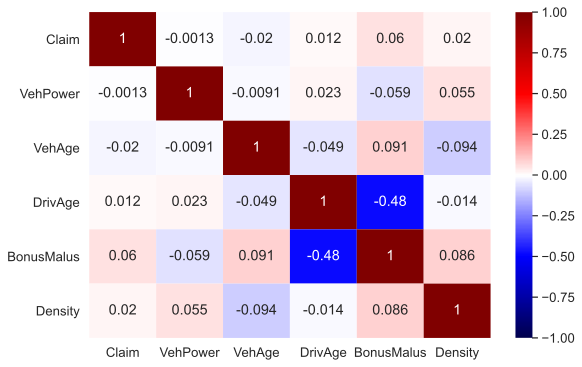

In [14]:
sns.heatmap(vis_cars.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

There's no correlation between target and features

In [15]:
#pairplot for correlation between target and features
#sns.pairplot(short_cars, corner=True, height=1.5, plot_kws={'size': 2}, hue='Claim');

### Split data set for train_validation and test(for final test)

In [16]:
df_train, df_test = train_test_split(short_cars,
                                     test_size=0.2, 
                                     random_state=10, stratify = short_cars['Claim'])

Split df_train(train+validation) to train and validation set

In [17]:
df = df_train.drop('Claim',axis=1)
X = pd.get_dummies(df)
y = df_train['Claim']
#df.set_index('IDpol', inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                            test_size=0.2, random_state=42, stratify= y)

### Check class imbalance

In [18]:
target_count = df_train.Claim.value_counts()

In [19]:
# print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 15208
Class 1: 792
Proportion: 19.2 : 1
Percentage of Majority Class: 95.05


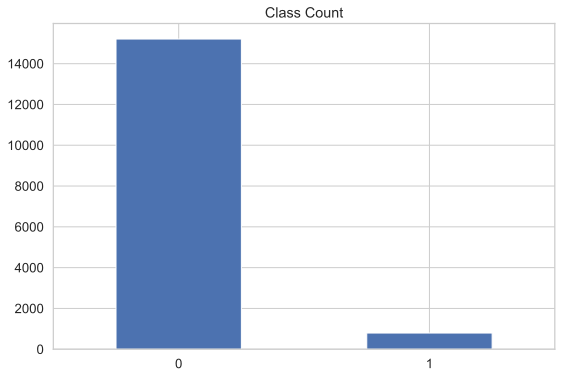

In [20]:
target_count.plot(kind='bar', title='Class Count', rot=0);

There's strong class imbalance, I'm gonna find the best way to handle it

I'll try 3 ways to handle class imbalnce: oversampling or synthetic: Adyson or SMOTE

Simple overfitting

In [21]:
clf = SVC().fit(X_train, y_train)

In [22]:
confusion_matrix(y_train, clf.predict(X_train))

array([[12166,     0],
       [  634,     0]])

The confusion matrix and decision region plot above show that we are still getting the minority class wrong whenever a minority sample is close to the region where the bulk of the majority points lie.

#### Over Sampling

In [23]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)

In [24]:
Counter(y_resampled)

Counter({0: 12166, 1: 12166})

In [25]:
clf_ros = SVC().fit(X_resampled, y_resampled)

In [26]:
confusion_matrix(y_train, clf_ros.predict(X_train))

array([[7685, 4481],
       [ 386,  248]])

ADASYN

In [27]:
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train,y_train)

In [28]:
Counter(y_adasyn)

Counter({0: 12166, 1: 11972})

In [29]:
clf_adasyn = SVC().fit(X_adasyn, y_adasyn)

In [30]:
confusion_matrix(y_train, clf_adasyn.predict(X_train))

array([[7879, 4287],
       [ 399,  235]])

SMOTE

In [31]:
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

In [32]:
Counter(y_smoted)

Counter({0: 12166, 1: 12166})

In [33]:
# Build classifier and plot decision region with SMOTE data
clf_smote = SVC().fit(X_smoted.to_numpy(), y_smoted.to_numpy())

In [34]:
confusion_matrix(y_train, clf_smote.predict(X_train))

array([[7801, 4365],
       [ 393,  241]])

I choose ADASYN because ADASYN does better at classifying the minority class

## I chose to use metric F1

Metric F1 is better for this model because it balances false positive and false negative predictions. It will cost money for car insurance company to predict False Positive and in the same time it's important to keep client and don't give high prices to too many clients

# Models

Let's find the model which gives the best F1 score with default hyperparametrs and default threshold=0.5

Scaling for KNN and logistic

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_adasyn.values)
X_test_scaled = scaler.fit_transform(X_test.values)

### KNN

In [36]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_adasyn)

KNeighborsClassifier()

In [37]:
y_predict_KNN = knn.predict(X_test_scaled)

In [38]:
print(classification_report(y_test, y_predict_KNN))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3042
           1       0.04      0.03      0.03       158

    accuracy                           0.92      3200
   macro avg       0.49      0.50      0.49      3200
weighted avg       0.91      0.92      0.91      3200



In [39]:
f1_knn = f1_score(y_test, y_predict_KNN)
f1_knn

0.030188679245283016

### Logistic Regression

In [40]:
logit = LogisticRegression(C=0.95)
logit.fit(X_train_scaled, y_adasyn)

LogisticRegression(C=0.95)

In [41]:
y_predict_logit = logit.predict(X_test_scaled)

In [42]:
f1_logit = f1_score(y_test, y_predict_logit)
f1_logit

0.09410363311494939

### Naive Bayes

#### Gaussian

In [43]:
nb = GaussianNB()
nb.fit(X_adasyn, y_adasyn)

GaussianNB()

In [44]:
y_predict_Gaussian = nb.predict(X_test)

In [45]:
f1_Gaussian = f1_score(y_test, y_predict_Gaussian)
f1_Gaussian

0.09296920395119117

#### Bernoulli

In [46]:
nb_B = BernoulliNB()
nb_B.fit(X_adasyn, y_adasyn)

BernoulliNB()

In [47]:
y_predict_Bernoulli = nb_B.predict(X_test)

In [48]:
f1_Bernoulli = f1_score(y_test, y_predict_Bernoulli)
f1_Bernoulli

0.07486631016042782

#### Multinomial

In [49]:
nb_M = MultinomialNB()
nb_M.fit(X_adasyn, y_adasyn)

MultinomialNB()

In [50]:
y_predict_Multinomial = nb_M.predict(X_test)

In [51]:
f1_Multinomial = f1_score(y_test, y_predict_Multinomial)
f1_Multinomial

0.09905660377358491

#### Decision trees

In [52]:
decisiontree = DecisionTreeClassifier(max_depth=4)
decisiontree.fit(X_adasyn, y_adasyn)

DecisionTreeClassifier(max_depth=4)

In [53]:
y_predict_decisiontree = decisiontree.predict(X_test)

In [54]:
f1_decisiontree = f1_score(y_test, y_predict_decisiontree)
f1_decisiontree

0.10026737967914437

### Random Forest

In [55]:
randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(X_adasyn, y_adasyn)

RandomForestClassifier()

In [56]:
y_predict_randomforest = randomforest.predict(X_test)

In [57]:
f1_randomforest = f1_score(y_test, y_predict_randomforest)
f1_randomforest

0.020725388601036267

### XGBoost

In [58]:
gbm = xgb.XGBClassifier( 
        n_estimators=30000,
        max_depth=4,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.05, 
        subsample=.8,
        min_child_weight=3,
        colsample_bytree=.8)

In [59]:
eval_set=[(X_adasyn,y_adasyn),(X_test,y_test)]

fit_model = gbm.fit(
                X_adasyn, y_adasyn, 
                eval_set=eval_set,
                eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                early_stopping_rounds=50,
                verbose=False) 

In [60]:
y_predict_gbm =  gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)

In [61]:
f1_gbm = f1_score(y_test, y_predict_gbm)
f1_gbm

0.011904761904761904

# Visualisatiom models

### Visualisation F1

In [62]:
f1_list = [f1_knn, f1_logit,f1_Gaussian, f1_Bernoulli, f1_Multinomial, f1_decisiontree, f1_randomforest, f1_gbm]
name_list = ['KNN', 'Logistic', 'Gaussian', 'Bernoulli', 'Multinomial', 'Decision Tree', 'Random Forest', 'XGBoost']

In [63]:
# create dictionary of f1 and name of the model to sort them and visualisate
f1_dict={}
for i, el in enumerate(f1_list):
    f1_dict[name_list[i]]=el

In [64]:
sorted_values = sorted(f1_dict.values()) # Sort the values
sorted_dict = {}

for i in sorted_values:
    for k in f1_dict.keys():
        if f1_dict[k] == i:
            sorted_dict[k] = f1_dict[k]
            break

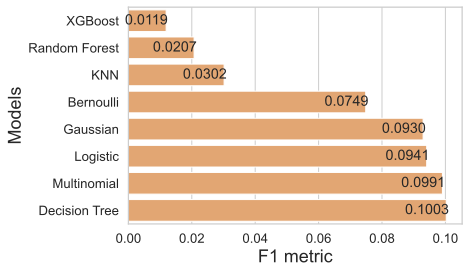

In [65]:
f, ax = plt.subplots(figsize=(6, 4))

sns.barplot(x=list(sorted_dict.values()), y=list(sorted_dict.keys()), label="Total", color='sandybrown')

for p in ax.patches:
    if p.get_width() != 0:
        width = p.get_width()    # get bar length
        ax.text(width - 0.013,       # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                '{:1.4f}'.format(width), # set variable to display, 2 decimals
                ha = 'left',   # horizontal alignment
                va = 'center')  # vertical alignment
        
ax.set_xlabel("F1 metric",fontsize=18)
ax.set_ylabel("Models",fontsize=18)

f.savefig("F1_metric.png")

plt.show()

### Visualisation ROC AUC

In [66]:
list_proba = [knn.predict_proba(X_test)[:,1], logit.predict_proba(X_test)[:,1], nb.predict_proba(X_test)[:,1], nb_B.predict_proba(X_test)[:,1], nb_M.predict_proba(X_test)[:,1], decisiontree.predict_proba(X_test)[:,1], randomforest.predict_proba(X_test)[:,1], gbm.predict_proba(X_test)[:,1]]

In [67]:
list_colors=['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:cyan', 'tab:gray','tab:olive', 'tab:red']

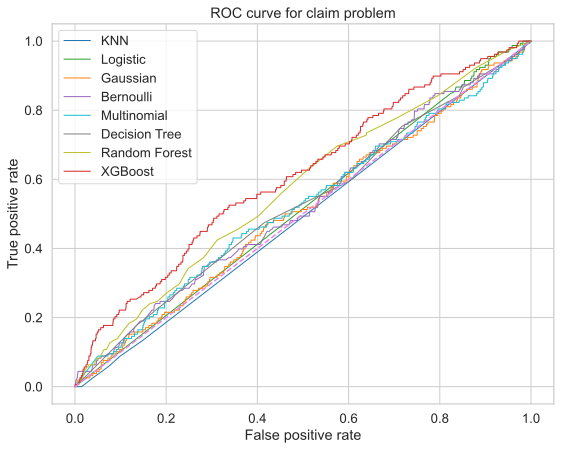

In [68]:
fig, ax = plt.subplots(figsize=(9, 7))
for i, el in enumerate(list_proba):
    fpr, tpr, thresholds = roc_curve(y_test, el)
    ax.plot(fpr, tpr, lw=1, label=name_list[i], c=list_colors[i])
    
ax.plot([0,1],[0,1],c='violet',ls='--')
#ax.xlim([-0.05,1.05])
#ax.ylim([-0.05,1.05])#
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve for claim problem')
ax.legend();

# Look deeper into models

I'm gonna look deeper into the models to improve F1 metric by adjusting threshold and tunning hyperparametrs and also try to engineer some features

## Decision tree

Decesion tree showed the best F1 metric, I'll try to improve it

In [69]:
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_adasyn, y_adasyn)
y_predict_decisiontree = decisiontree.predict(X_test)
f1_decisiontree = f1_score(y_test, y_predict_decisiontree)
f1_decisiontree

0.08130081300813008

In [70]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [71]:
dt = DecisionTreeClassifier()

### Adjusting hyperparameters

In [72]:
params = {
    'max_depth': [6],
    'max_leaf_nodes' : range(6, 20, 1)
}

In [73]:
imba_pipeline = make_pipeline(ADASYN(random_state=42), 
                              DecisionTreeClassifier())

In [74]:
new_params = {'decisiontreeclassifier__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
grid_imba.fit(X_train, y_train);

In [75]:
grid_imba.best_params_

{'decisiontreeclassifier__max_depth': 6,
 'decisiontreeclassifier__max_leaf_nodes': 16}

In [76]:
grid_imba.best_score_

0.09876084642938875

Yay! Score is better!

Let's check if model overfitting

In [77]:
imba_pipeline = make_pipeline(ADASYN(random_state=42), 
                              DecisionTreeClassifier(max_depth=6))

In [78]:
cross_val_score(imba_pipeline, X_train, y_train, scoring='f1', cv=kf)

array([0.08211144, 0.07641196, 0.09819967, 0.1408046 , 0.09984871])

Oh! Model is overfitted! I'll use logistic regression then.

Logistic was giving just a little worse f1 score but can handle overfitting

### Logistic regression

In [79]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_adasyn)
y_predict_lr = lr.predict(X_test_scaled)
f1_lr = f1_score(y_test, y_predict_lr)
f1_lr

0.09410363311494939

Scaling feauture without handlening imbalancing for using in Grid Search and cross validation

In [80]:
scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_train.values)
X_test_scaled2 = scaler2.fit_transform(X_test.values)

### Tuning hyperparametrs

In [81]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [82]:
params_lr = {
    'C': [100, 10, 1.0, 0.1, 0.01],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty' :  ['none', 'l1', 'l2', 'elasticnet']
   
}

In [83]:
imba_pipeline_lr = make_pipeline(ADASYN(random_state=42), 
                              LogisticRegression())

In [84]:
new_params_lr = {'logisticregression__' + key: params_lr[key] for key in params_lr}
grid_imba_lr = GridSearchCV(imba_pipeline_lr, param_grid=new_params_lr, cv=kf, scoring='f1',
                        return_train_score=True)
grid_imba_lr.fit(X_train_scaled2, y_train);

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: U

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sk

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/User

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 


/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 450, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 454, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sk

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 450, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/User

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 454, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in 

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/User

In [85]:
grid_imba_lr.best_params_

{'logisticregression__C': 0.01,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'saga'}

In [86]:
grid_imba.best_score_

0.09876084642938875

Yay! F1 is a little better after tuning hyperparameters

Let's check overfittng

In [87]:
imba_pipeline_lr_tuned = make_pipeline(ADASYN(random_state=42), 
                              LogisticRegression(C=0.01, penalty = 'l1', solver = 'saga'))

In [88]:
params_lr_tuned = {
    'C': [0.01],
    'penalty' : ['l1'],
    'solver' : ['saga']    
}

In [89]:
new_params_lr_tuned = {'logisticregression__' + key: params_lr_tuned[key] for key in params_lr_tuned}
grid_imba_lr_tuned = GridSearchCV(imba_pipeline_lr_tuned, param_grid=new_params_lr_tuned, cv=kf, scoring='f1',
                        return_train_score=True)
grid_imba_lr_tuned.fit(X_train_scaled2, y_train);

### Adjust threshold

#### adjust threshold

In [90]:
lr_tuned = LogisticRegression(C=0.01, penalty = 'l1', solver = 'saga')
lr_tuned.fit(X_train_scaled, y_adasyn)

LogisticRegression(C=0.01, penalty='l1', solver='saga')

In [91]:
f1_lr_max= f1_score(y_test, (lr_tuned.predict_proba(X_test_scaled)[:,1] > 0))
threshold = 0
for i in range(0, 10001, 1):
    y_predict_lr_tr = (lr_tuned.predict_proba(X_test_scaled)[:,1] > i/10000)
    f1_lr_tr = f1_score(y_test, y_predict_lr_tr)
    if f1_lr_tr > f1_lr_max:
                f1_lr_max = f1_lr_tr
                threshold = i/10000
                
print("The best f1:", f1_lr_max)
print("at threshold:", threshold)

The best f1: 0.10928961748633881
at threshold: 0.7496


F1 better after adjusting

### Feature engineering

In [92]:
poly = PolynomialFeatures(degree=2, interaction_only=True)

In [93]:
X_train_poly = poly.fit_transform(X_train_scaled2)

In [94]:
cross_val_score(imba_pipeline_lr_tuned, X_train_poly, y_train, scoring='f1', cv=kf)

/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/albinasitdikova/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


array([0.10384216, 0.1148429 , 0.08351178, 0.12371134, 0.10621242])

it's a little  worse after polynomial feature engeenering

### Feature importance

In [95]:
importance = lr_tuned.coef_

In [96]:
importance_list = list(importance)

In [97]:
columns_list = list(X_train.columns.values)

In [98]:
imp_dict={}
for i, el in enumerate(importance_list[0]):
    
    imp_dict[columns_list[i]]=el

In [99]:
sorted_values = sorted(imp_dict.values()) # Sort the values
sorted_dict = {}

for i in sorted_values:
    for k in imp_dict.keys():
        if imp_dict[k] == i:
            sorted_dict[k] = imp_dict[k]
            break

## Visualisation Features' importance

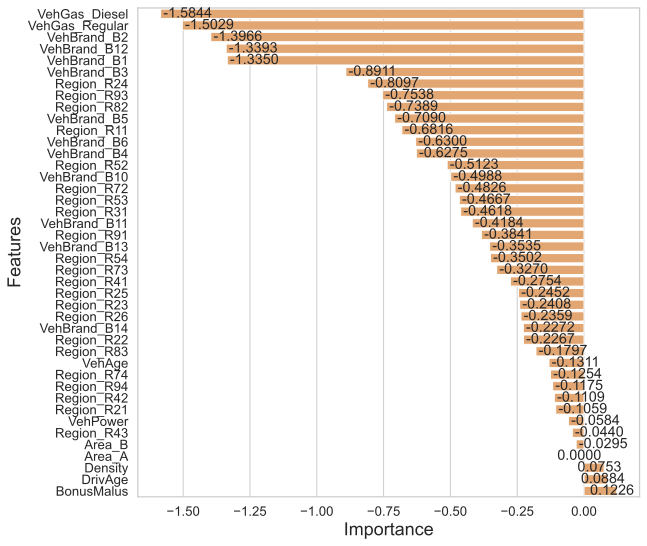

In [100]:
f, ax = plt.subplots(figsize=(9, 9))

sns.barplot(x=list(sorted_dict.values()), y=list(sorted_dict.keys()), label="Total", color='sandybrown')

for p in ax.patches:
    if p.get_width() < 0:
        width = p.get_width()    # get bar length
        ax.text(width + 0.01,       # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                '{:1.4f}'.format(width), # set variable to display, 2 decimals
                ha = 'left',   # horizontal alignment
                va = 'center')  # vertical alignment
    else:
        width = p.get_width()    # get bar length
        ax.text(width - 0.1,       # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                '{:1.4f}'.format(width), # set variable to display, 2 decimals
                ha = 'left',   # horizontal alignment
                va = 'center')  # vertical alignment
        
ax.set_xlabel("Importance",fontsize=18)
ax.set_ylabel("Features",fontsize=18)

f.savefig("Feature_importance.png")

plt.show()

## Final test set

Let's check F1 metric on our adjusted model on test set

In [101]:
df_f = df_test.drop('Claim',axis=1)
X_final_test = pd.get_dummies(df_f)
y_final_test = df_test['Claim']

In [102]:
#handle imbalancimg on train set
X_adasyn_final, y_adasyn_final = ADASYN(random_state=42).fit_sample(X,y)

In [103]:
#scaling final test and training sets
scaler_final = StandardScaler()
X_train_scaled_final = scaler_final.fit_transform(X_adasyn_final.values)
X_test_scaled_final = scaler_final.fit_transform(X_final_test.values)

In [104]:
lr_final = LogisticRegression(C=0.01, penalty = 'l1', solver = 'saga')
lr_final.fit(X_train_scaled_final, y_adasyn_final)

LogisticRegression(C=0.01, penalty='l1', solver='saga')

In [105]:
y_predict_final = lr_final.predict(X_test_scaled_final)

In [106]:
f1_final = f1_score(y_final_test, y_predict_final)
f1_final

0.09455587392550144

## Result

The result is 0.0946 on the final test.